# Auxilary Libraries
We install albumentations library and ipyvolumes. They are not needed to work with the dataset, but they are used in
the example in this notebook.

In [58]:
!pip install --upgrade albumentations ipyvolume

# Working with Synthesis AI face dataset
At first, we add some imports for the visualisation.

In [58]:
%matplotlib inline

In [59]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

We use `FaceApiDataset` class to access synthesis datasets.


In [60]:
from face_api_dataset import FaceApiDataset, Modality

**Warning!** Some of modalities requires additional libraries to be installed:
`SEGMENTS` and `RGB` modalities use `opencv-python` library,
 while `DEPTH`, `ALPHA` and `NORMALS` modalities
 use `tiffile`  and `imagecodecs` libraries for effective work with floating point tiff files.
 If dataset with these modalities will be created without corresponding libraries present, an `ImportError` is raised.


In [61]:
dataset = FaceApiDataset("test_dataset")

The only required parameter is dataset root. By default all the modailities are loaded.

In [62]:
len(dataset)

15

There are 16 items in the test dataset. Let's explore them closer.

In [63]:
item = dataset[0]
item2 = dataset[2]

Each item is a dict with different modalities as keys.

In [64]:
print(item.keys())

dict_keys([<Modality.RENDER_ID: 1>, <Modality.RGB: 2>, <Modality.NORMALS: 3>, <Modality.DEPTH: 4>, <Modality.ALPHA: 5>, <Modality.SEGMENTS: 6>, <Modality.LANDMARKS: 7>, <Modality.LANDMARKS_3D: 8>, <Modality.PUPILS: 9>, <Modality.PUPILS_3D: 10>, <Modality.IDENTITY: 11>, <Modality.IDENTITY_METADATA: 12>, <Modality.HAIR: 13>, <Modality.FACIAL_HAIR: 14>, <Modality.EXPRESSION: 15>, <Modality.GAZE: 16>, <Modality.FACE_BBOX: 17>, <Modality.CAM_INTRINSICS: 18>])


`RENDER_ID` is the id of the image (number used in the stem of the file).

In [65]:
item[Modality.RENDER_ID]

0

`RGB` modality is the rendered image.

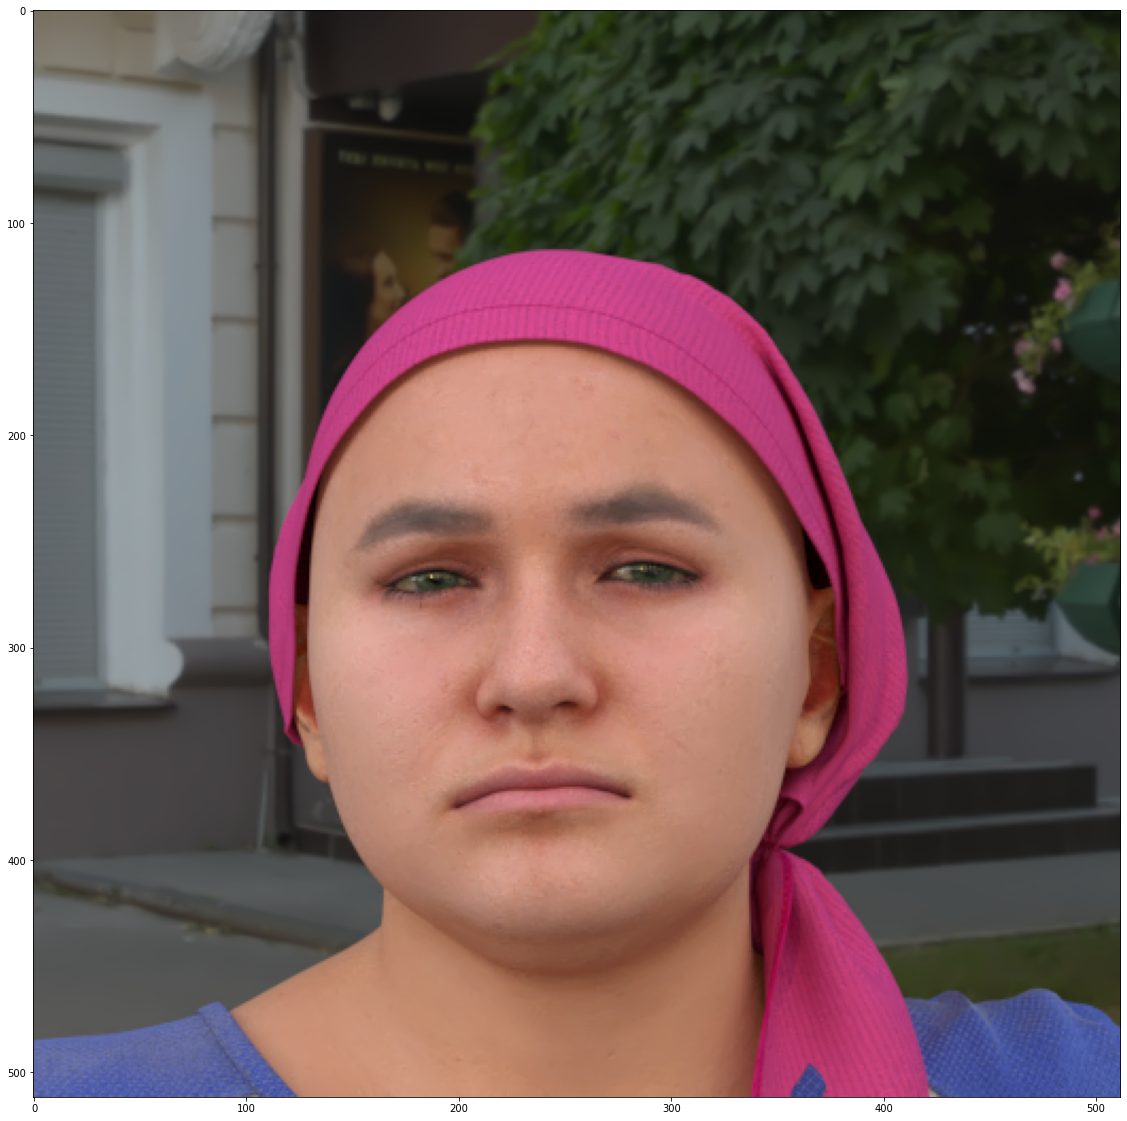

In [66]:
plt.figure(figsize=(20,20))
plt.imshow(item[Modality.RGB])

`FACE_BBOX` modality is a face bounding box in format `x0, y0, x1, y1`.

In [67]:
def plot_bbox(image, face_bbox):
    plt.figure(figsize=(20,20))

    image = cv2.rectangle(image.copy(), face_bbox[:2], face_bbox[2:], (255, 0, 0), 2)
    plt.imshow(image)

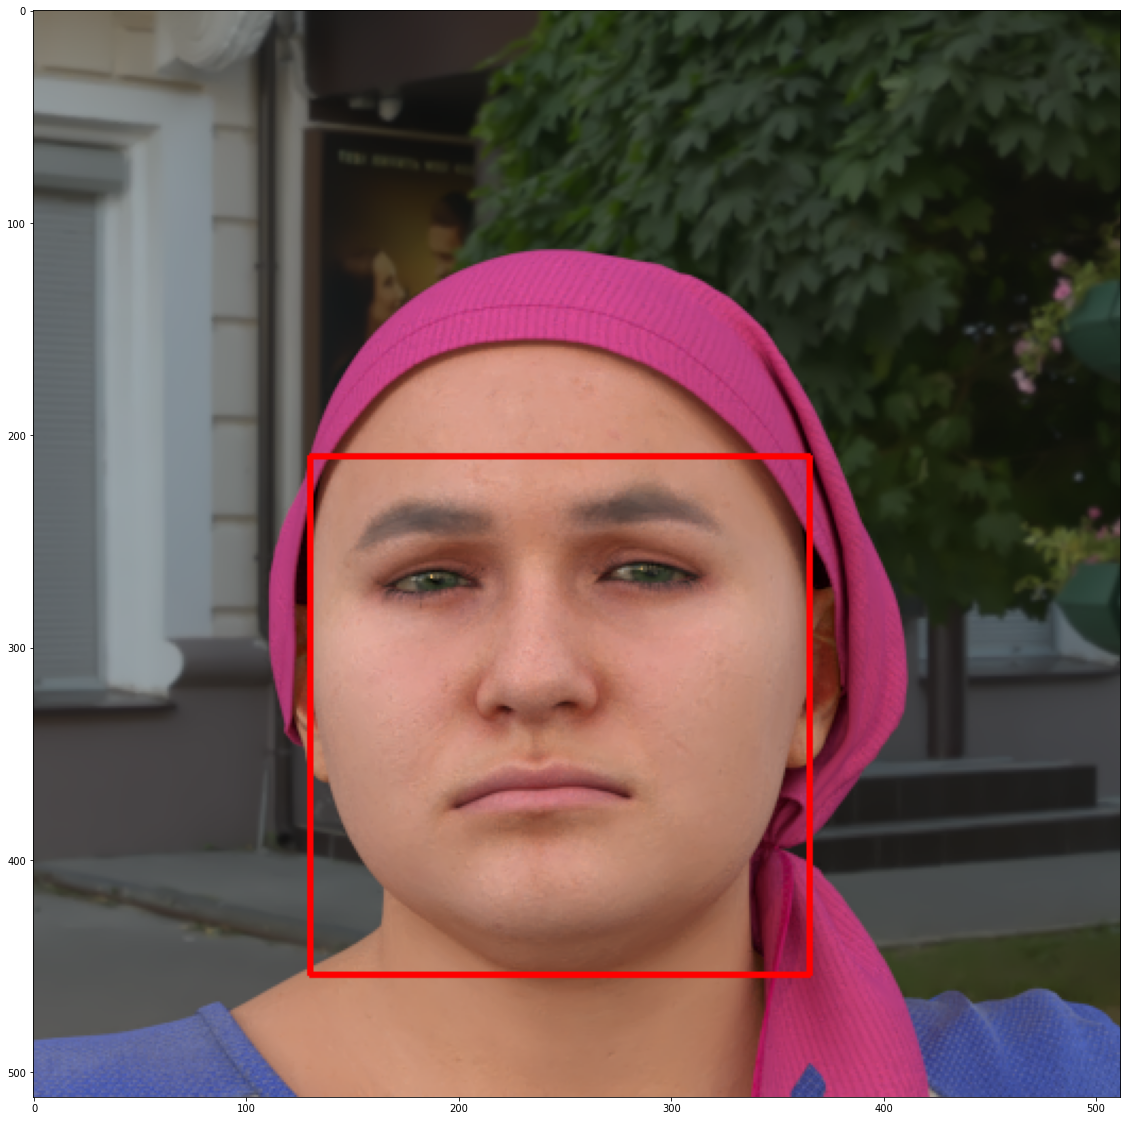

In [68]:
plot_bbox(item[Modality.RGB], item[Modality.FACE_BBOX])


`SEGMENTS` modality is the segmentation map. We can see mapping of different segments to numbers with `segments`
method o the dataset.

In [69]:
dataset.segments

{'default': 0,
 'background': 0,
 'beard': 1,
 'body': 2,
 'brow': 3,
 'cheek_left': 4,
 'cheek_right': 5,
 'chin': 6,
 'clothing': 7,
 'ear_left': 8,
 'ear_right': 9,
 'eye_left': 10,
 'eye_right': 11,
 'eyelashes': 12,
 'eyelid': 13,
 'eyes': 14,
 'forehead': 15,
 'glasses': 16,
 'hair': 17,
 'head': 18,
 'headphones': 19,
 'headwear': 20,
 'jaw': 21,
 'jowl': 22,
 'lip_lower': 23,
 'lip_upper': 24,
 'mask': 25,
 'mouth': 26,
 'mouthbag': 27,
 'mustache': 28,
 'neck': 29,
 'nose': 30,
 'nose_outer': 31,
 'nostrils': 32,
 'shoulders': 33,
 'smile_line': 34,
 'teeth': 35,
 'temples': 36,
 'tongue': 37,
 'undereye': 38}

**Warning!** `render_id.segments.png` file should not be loaded as is for the segmentation as segment mapping differs
between different files. Fortunately `FaceApiDataset` class solves this issue for us.

Segmentation is an integral numpy array with the same dimensions as the original image.
To display it we write a simple helper function:

In [70]:
def discrete_show(data):
    cmap = plt.get_cmap('RdBu', np.max(data) - np.min(data) + 1)
    plt.imshow(data, cmap=cmap, vmin=np.min(data) - .5,
               vmax = np.max(data) + .5, interpolation="nearest")

Let's look at segmentation results.

In [71]:
cv2.imwrite("test.png", item[Modality.RGB][:,:,::-1])

True

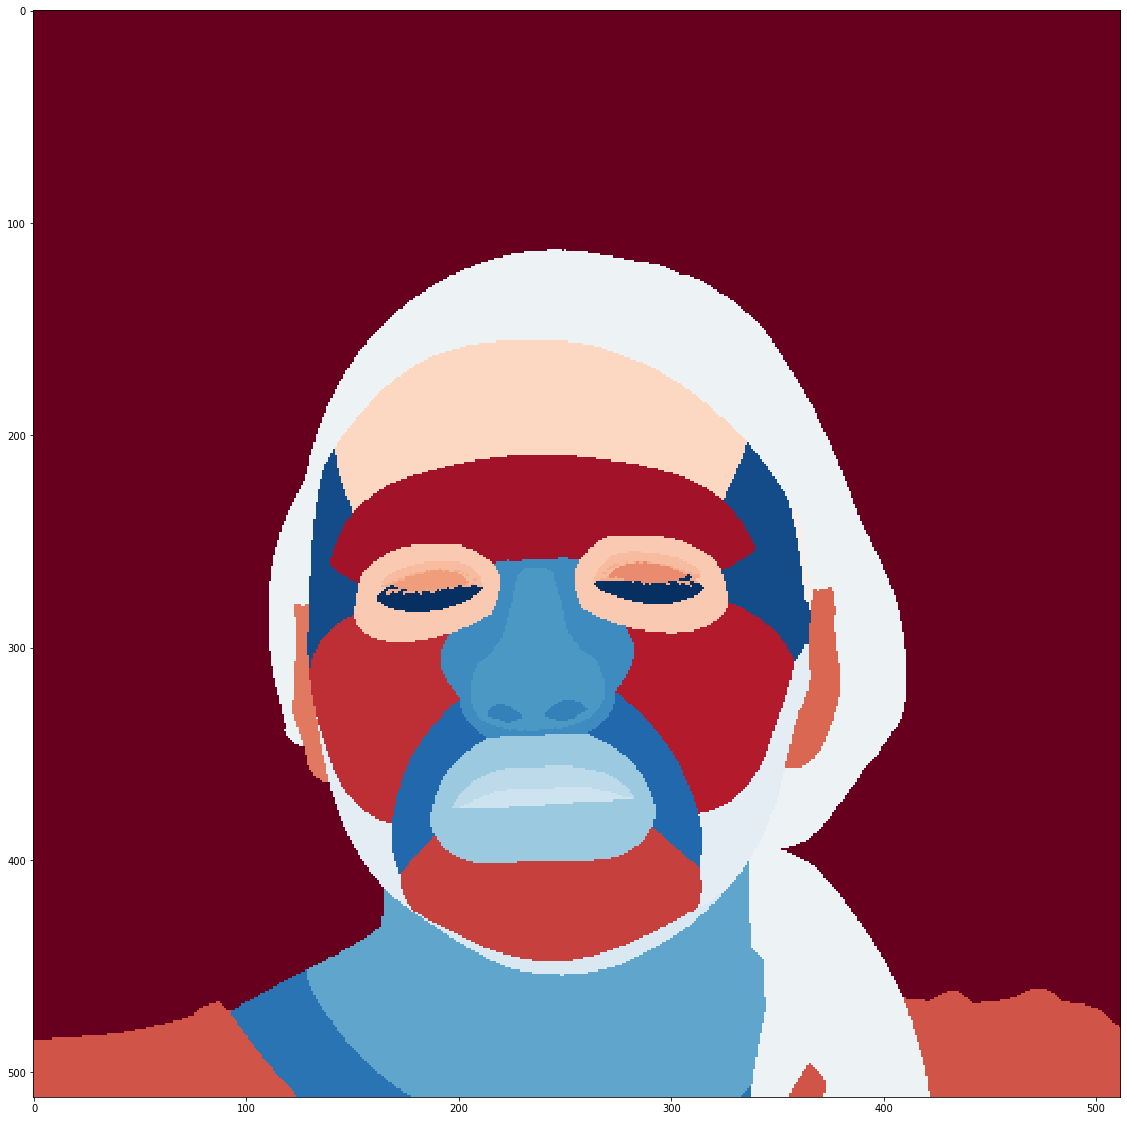

In [72]:
plt.figure(figsize=(20,20))
discrete_show(item[Modality.SEGMENTS])

Different datasets define different segments. If we need to comply to some standards, we may define our own
segmentation mapping:

In [73]:
segments = { 'default': 0,
             'background': 0,
             'beard': 1,
             'body': 3,
             'brow': 1,
             'cheek_left': 1,
             'cheek_right': 1,
             'chin': 1,
             'clothing': 3,
             'ear_left': 1,
             'ear_right': 1,
             'eye_left': 1,
             'eye_right': 1,
             'eyelashes': 1,
             'eyelid': 1,
             'eyes': 1,
             'forehead': 1,
             'glasses': 0,
             'hair': 2,
             'head': 1,
             'headphones': 0,
             'headwear': 0,
             'jaw': 1,
             'jowl': 1,
             'lip_lower': 1,
             'lip_upper': 1,
             'mask': 0,
             'mouth': 1,
             'mouthbag': 1,
             'mustache': 1,
             'neck': 3,
             'nose': 1,
             'nose_outer': 1,
             'nostrils': 1,
             'shoulders': 3,
             'smile_line': 1,
             'teeth': 1,
             'temples': 1,
             'tongue': 1,
             'undereye': 1 }

We can provide this mapping during the creation of the dataset to change the segmentation modality output.

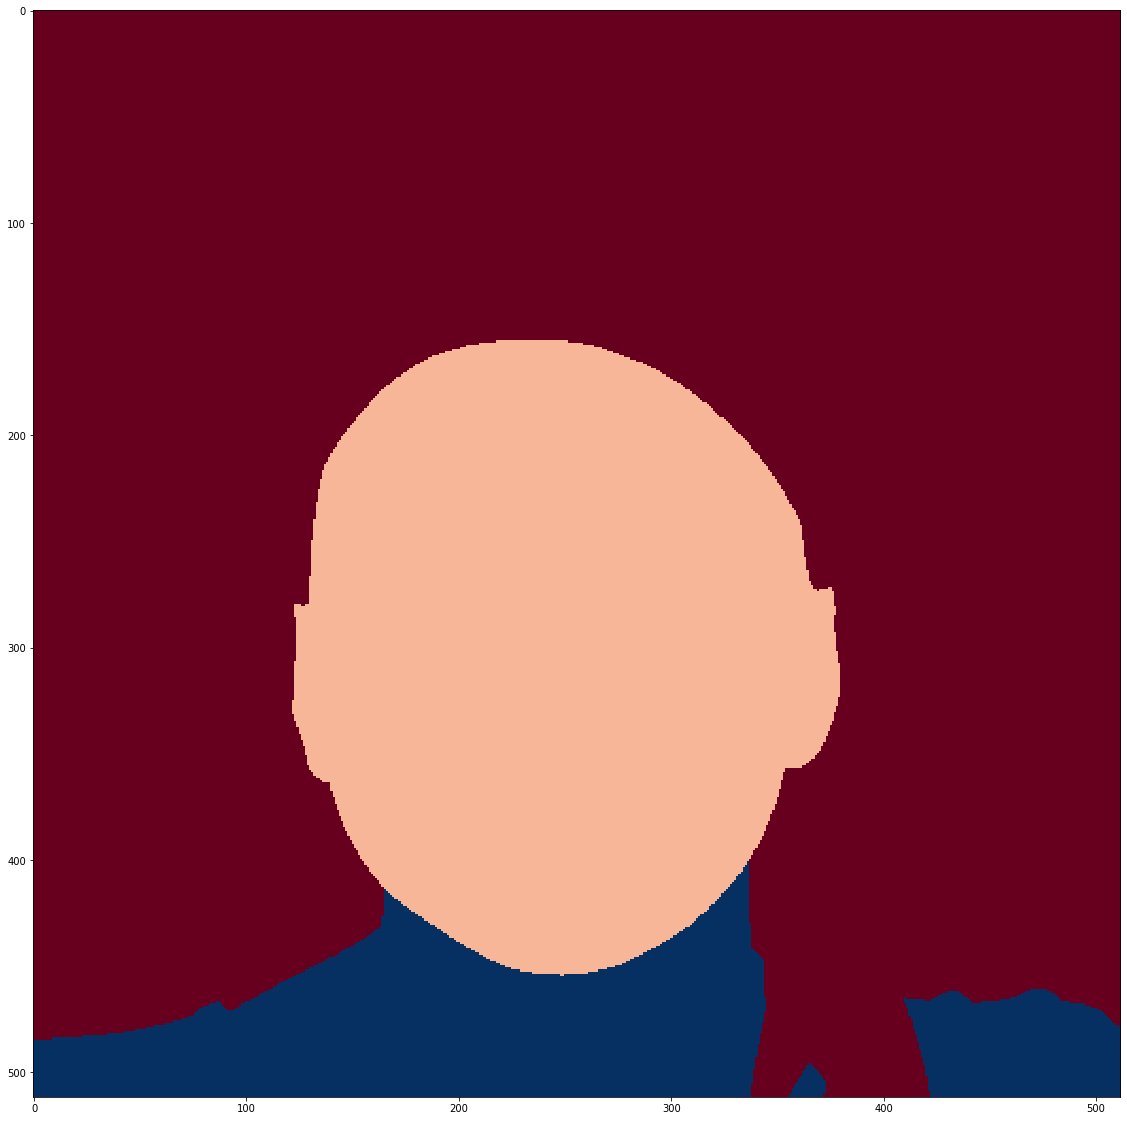

In [74]:
plt.figure(figsize=(20,20))
discrete_show(FaceApiDataset("test_dataset", segments=segments)[0][Modality.SEGMENTS])

Normals modality is a 3-channel numpy array with each chanel values from `-1.0` to `1.0`.

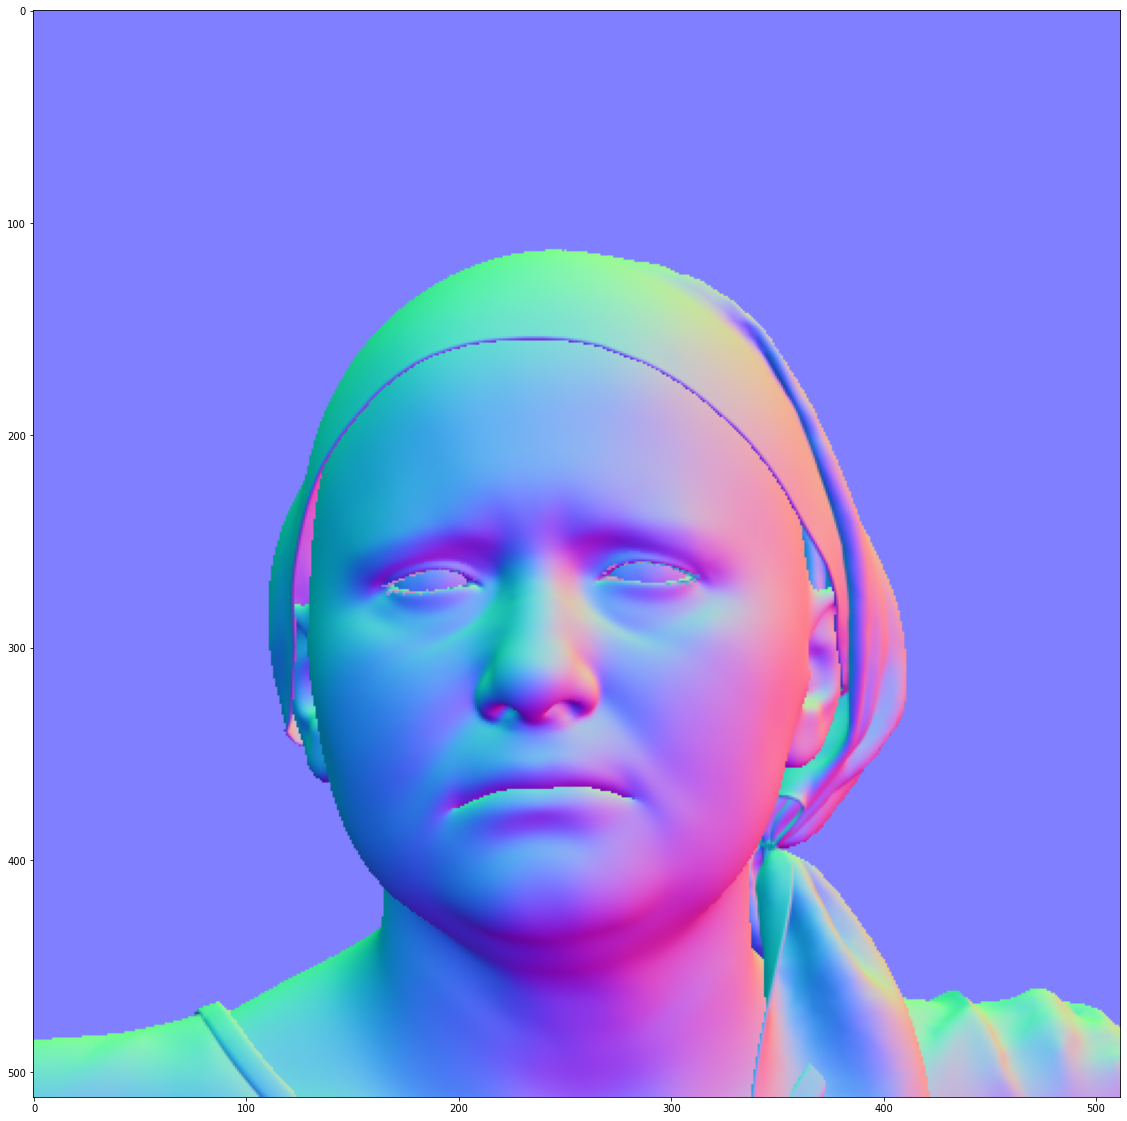

In [75]:
plt.figure(figsize=(20,20))
plt.imshow(((item[Modality.NORMALS] + 1) / 2 * 255).astype(np.uint8))

Alpha channel is a grayscale image, useful ex. for matting.
Unlike segmentation, it can represent semi-transparent parts of the face (ex. hair).

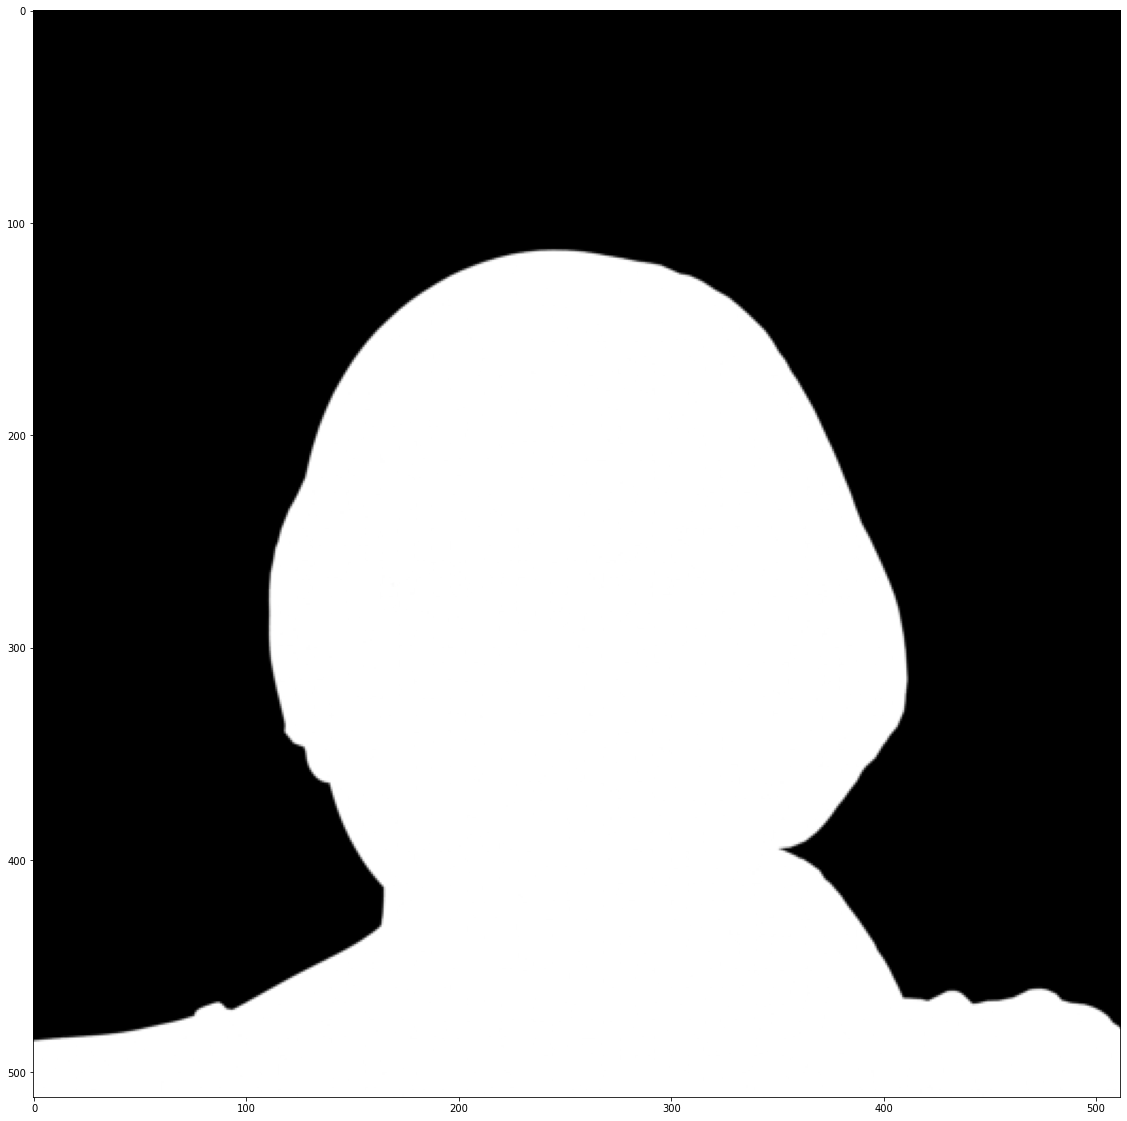

In [76]:
plt.figure(figsize=(20,20))
plt.imshow((item[Modality.ALPHA]).astype(np.uint8), cmap="gray")

Depth modality is an array of positive floats. Background is set to have depth equal to `0`,
and for the rest of the image it represents distance to camera space in centimeters.

We write a simple helper function and display it.

In [77]:
def depth_show(img, shift=0.1):
    eps = 0.003
    d_min = img[img > eps].min()
    d_max = img[img > eps].max()
    d_img = np.copy(img)
    d_img[d_img < eps] = 0
    d_img[d_img > eps] = (d_img[d_img > eps] - d_min) / (d_max - d_min) *  (1 - shift) + shift
    plt.imshow((d_img * 255).astype(np.uint8), cmap="gray_r")

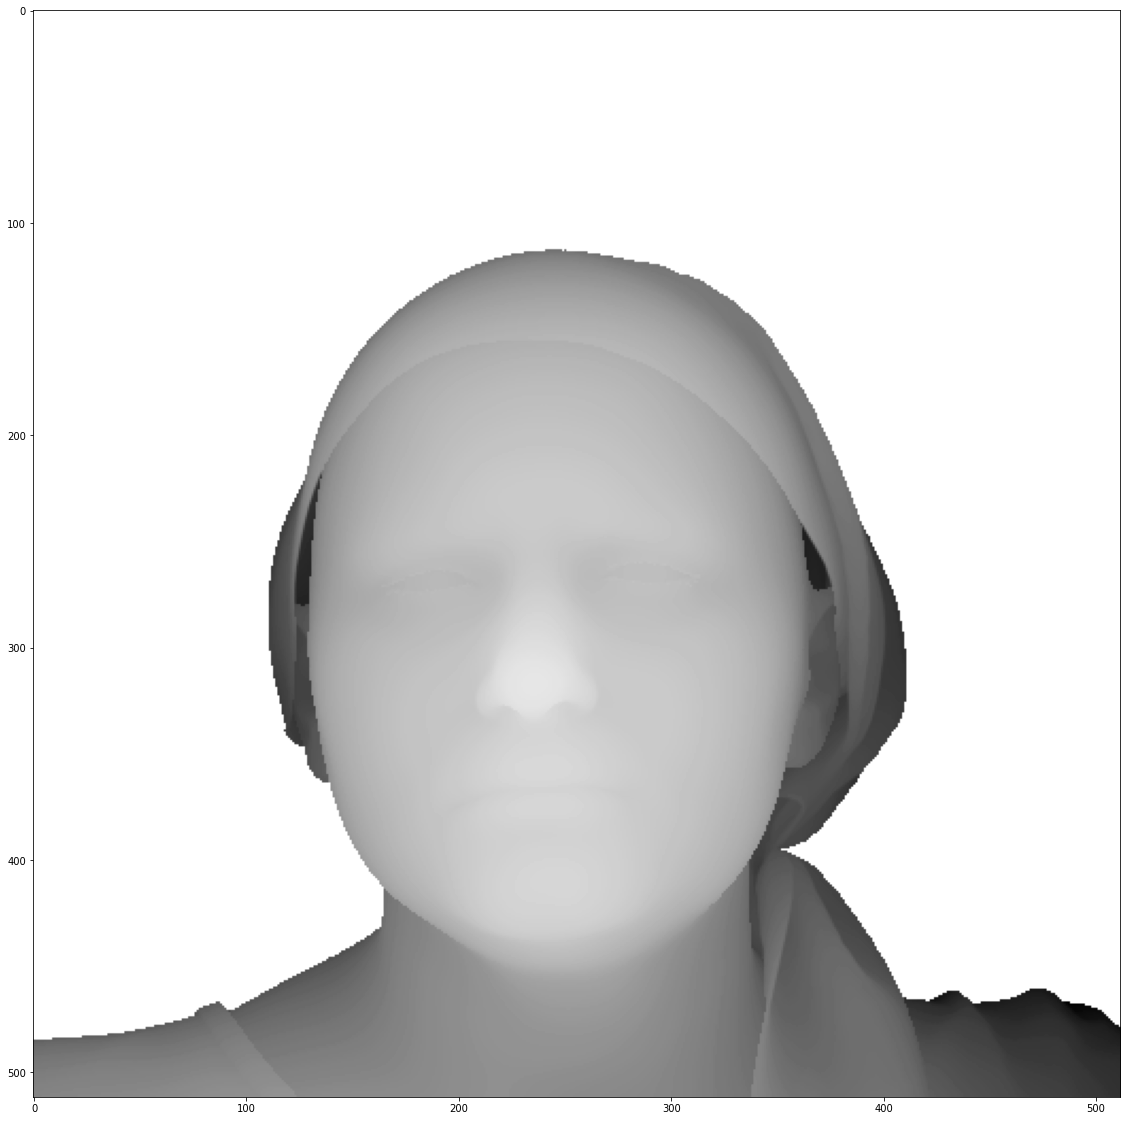

In [78]:
plt.figure(figsize=(20,20))
depth_show(item[Modality.DEPTH])

Landmarks are in iBUG format. Each of 68 landmarks is represented by its `x` and `y` coordinates in image space,
`y` coordinate going from top to bottom.

In [79]:
def landmark_show(img, landmarks, radius = 2):
    l_img = np.copy(img)
    for landmark in landmarks.astype(np.uint32):
        cv2.circle(l_img, tuple(landmark), radius=radius, color=(255, 0, 0), thickness=cv2.FILLED)
    plt.imshow(l_img)

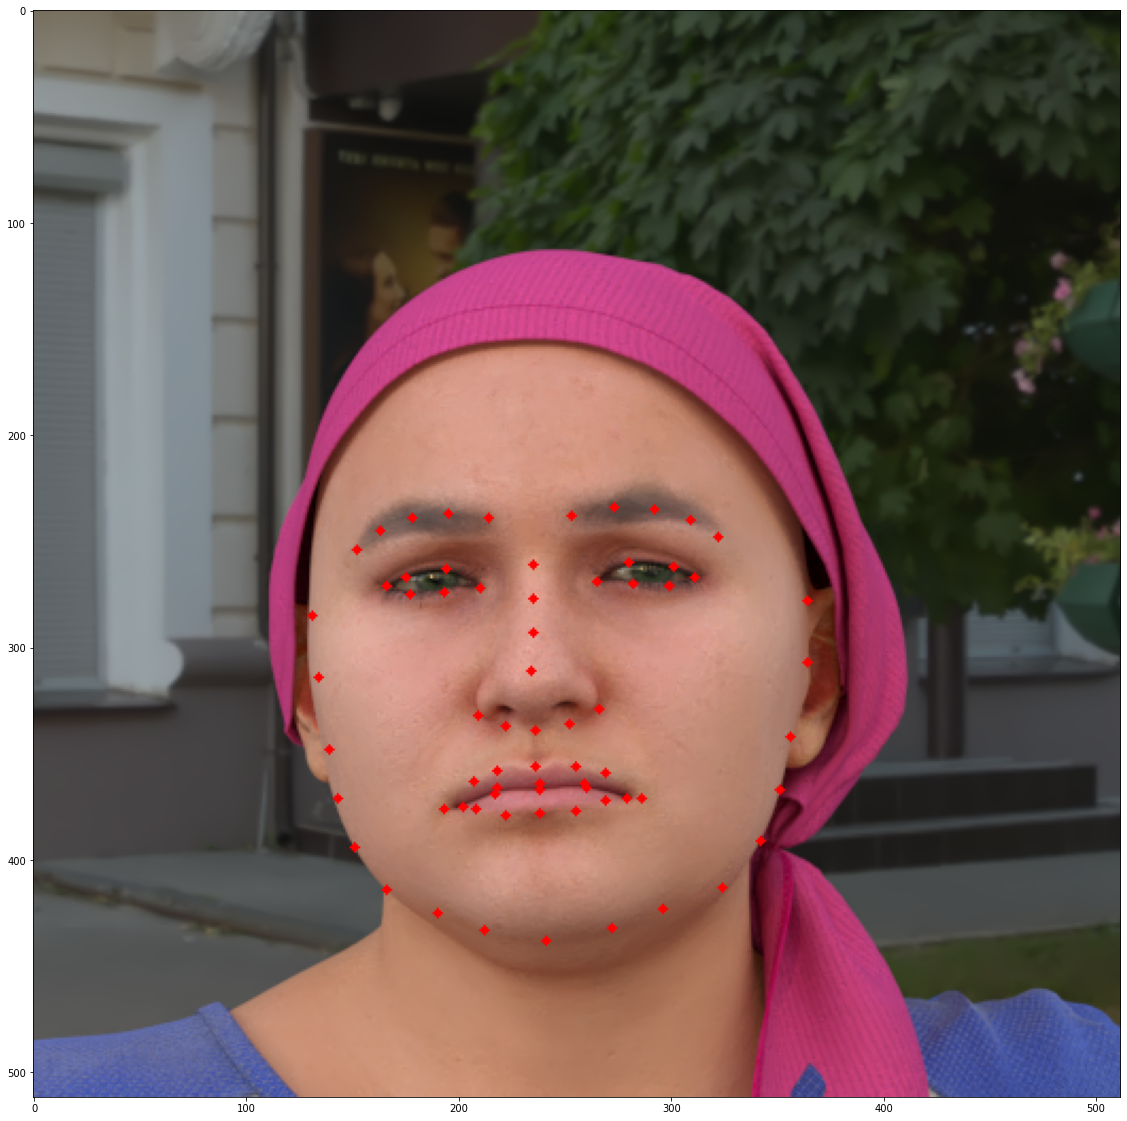

In [80]:
plt.figure(figsize=(20,20))
landmark_show(item[Modality.RGB], item[Modality.LANDMARKS])

**Warning!** Contour landmarks are slightly different from iBUG.
Instead of showing the contour of the face in our dataset they have the fixed position on the face.

This looks a bit strange on rotated images, but these landmarks are more useful for multiple tasks,
such as facial pose retrival and special effects.

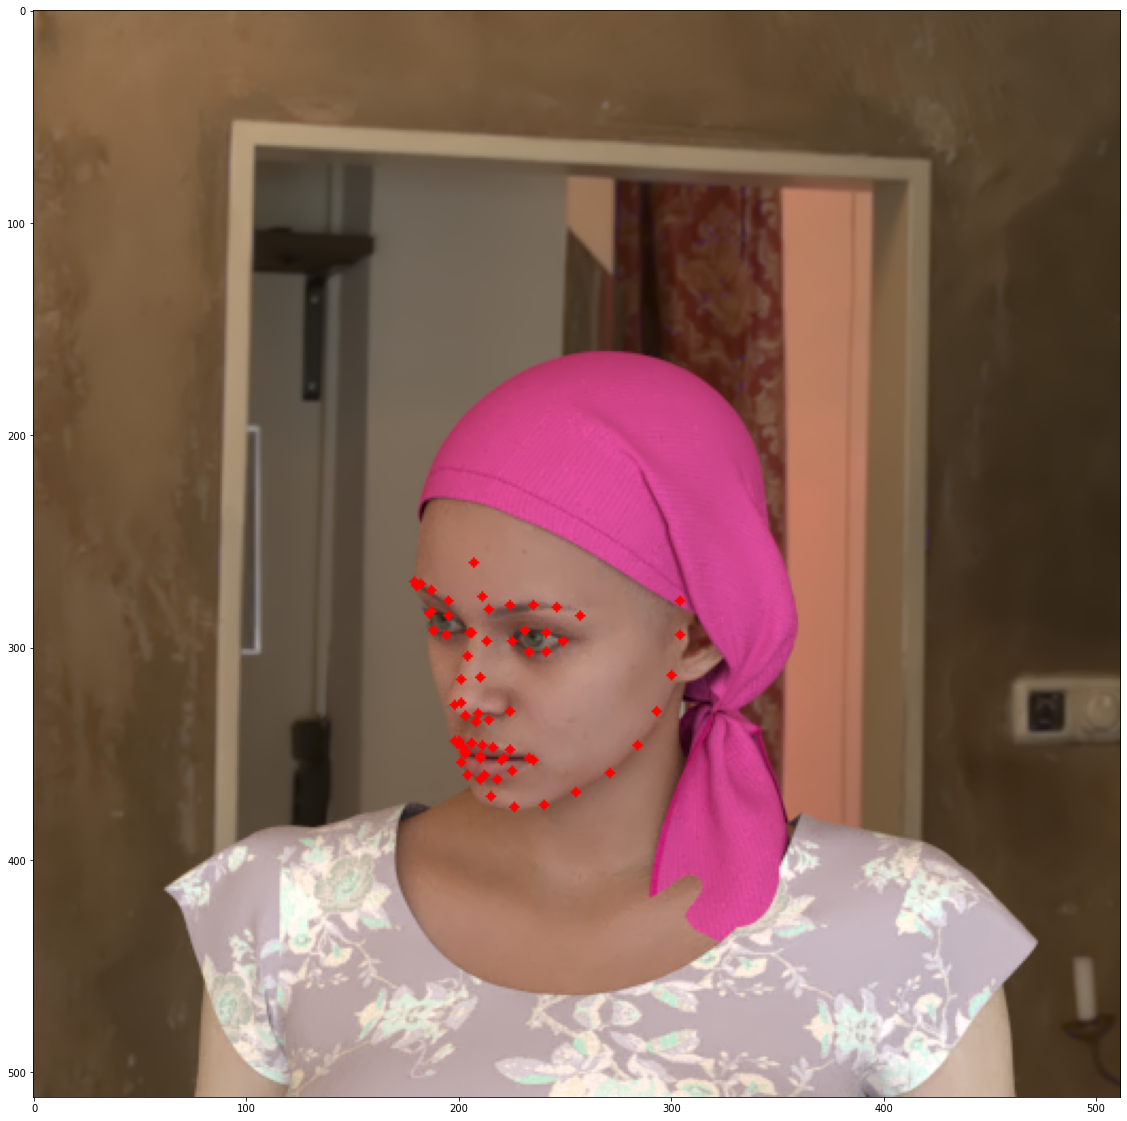

In [81]:
plt.figure(figsize=(20,20))
landmark_show(item2[Modality.RGB], item2[Modality.LANDMARKS])

iBUG does not provide landmarks for pupiles, but they can be important in multiple tasks.
Thus we provide two additional landmarks for them:

In [82]:
item[Modality.PUPILS]

array([[291.4708252 , 264.13796997],
       [189.86621094, 268.00531006]])

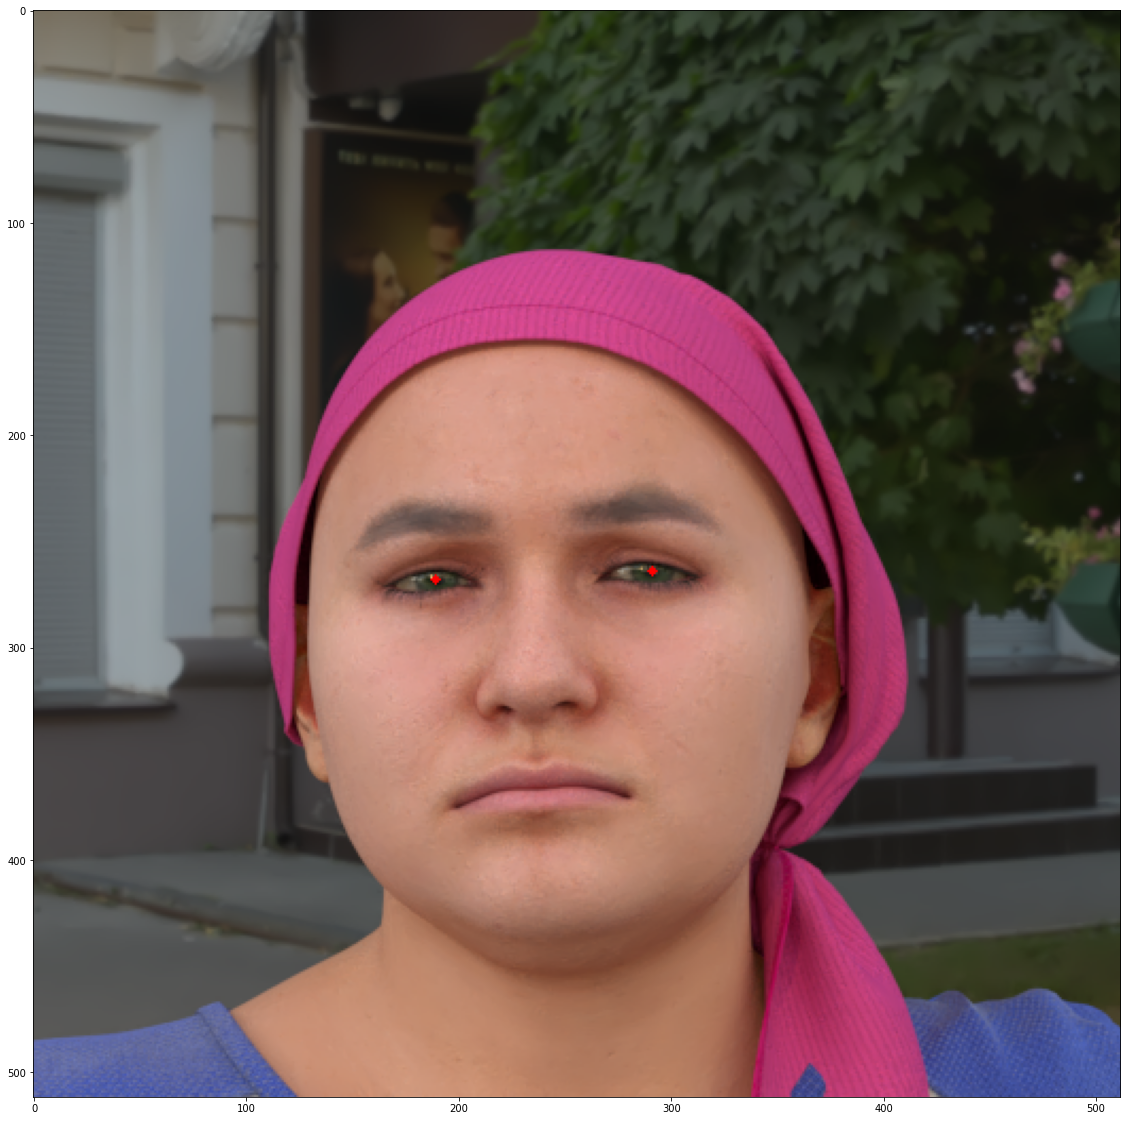

In [83]:
plt.figure(figsize=(20,20))
landmark_show(item[Modality.RGB], item[Modality.PUPILS])

## 3D Modalities
One of benefites of synthetic data is that we can also provide 3D cordinates for many modalities.

In [88]:
import ipyvolume as ipv

def plot_keypoints(keypoints):
    fig = ipv.figure()

    mean = keypoints.mean(axis=0)
    scale = (keypoints.max(axis=0) - keypoints.min(axis=0) + 1e-6).max()
    print(mean, scale)
    ipv.pylab.xlim(mean[0] - scale / 2, mean[0] + scale / 2)
    ipv.pylab.ylim(mean[1] - scale / 2, mean[1] + scale / 2)
    ipv.pylab.zlim(mean[2] - scale / 2, mean[2] + scale / 2)

    ipv.scatter(keypoints[:, 0], keypoints[:, 1], keypoints[:, 2], size=1, marker="sphere")
    return fig 

In [89]:
landmarks3d = item[Modality.LANDMARKS_3D]
plot_keypoints(landmarks3d)


[-0.01024522 -0.04447526 -0.97862362] 0.15787915302610397


Figure(camera=PerspectiveCamera(fov=46.0, position=(0.0, 0.0, 2.0), projectionMatrix=(1.0, 0.0, 0.0, 0.0, 0.0,…

In [90]:
pupils3d = item[Modality.PUPILS_3D]
print(pupils3d)
plot_keypoints(pupils3d)

[[ 0.02239008 -0.0051369  -0.97935557]
 [-0.04192079 -0.00760989 -0.98347205]]
[-0.00976535 -0.0063734  -0.98141381] 0.06431187106466293


Figure(camera=PerspectiveCamera(fov=46.0, position=(0.0, 0.0, 2.0), projectionMatrix=(1.0, 0.0, 0.0, 0.0, 0.0,…

Let's plot pupils alongside landmarks:

In [91]:
fig = ipv.figure()
mean = landmarks3d.mean(axis=0)
scale = (landmarks3d.max(axis=0) - landmarks3d.min(axis=0) + 1e-6).max()
ipv.pylab.xlim(mean[0] - scale / 2, mean[0] + scale / 2)
ipv.pylab.ylim(mean[1] - scale / 2, mean[1] + scale / 2)
ipv.pylab.zlim(mean[2] - scale / 2, mean[2] + scale / 2)

ipv.scatter(landmarks3d[:, 0], landmarks3d[:, 1], landmarks3d[:, 2], size=1, marker="sphere")
ipv.scatter(pupils3d[:, 0], pupils3d[:, 1], pupils3d[:, 2], size=1, marker="sphere", color="blue")


fig

Figure(camera=PerspectiveCamera(fov=46.0, position=(0.0, 0.0, 2.0), projectionMatrix=(1.0, 0.0, 0.0, 0.0, 0.0,…

Gaze direction can be important in multiple tasks. We provide gaze direction in
format `(horizontale_angle, vertical_angle)`.

In [92]:
item[Modality.GAZE]

array([[-0.09519605,  0.14826371,  0.98435539],
       [-0.23548879,  0.09513157,  0.96720988]])

In [94]:
fig = ipv.figure()
mean = landmarks3d.mean(axis=0)
scale = (landmarks3d.max(axis=0) - landmarks3d.min(axis=0) + 1e-6).max()
ipv.pylab.xlim(mean[0] - scale / 2, mean[0] + scale / 2)
ipv.pylab.ylim(mean[1] - scale / 2, mean[1] + scale / 2)
ipv.pylab.zlim(mean[2] - scale / 2, mean[2] + scale / 2)

#ipv.scatter(landmarks3d[:, 0], landmarks3d[:, 1], landmarks3d[:, 2], size=1, marker="sphere")
ipv.quiver(pupils3d[:, 0], pupils3d[:, 1], pupils3d[:, 2], item[Modality.GAZE][:, 0], item[Modality.GAZE][:, 1], item[Modality.GAZE][:, 2], size=1, marker="sphere", color="blue")


fig

Figure(camera=PerspectiveCamera(fov=46.0, position=(0.0, 0.0, 2.0), projectionMatrix=(1.0, 0.0, 0.0, 0.0, 0.0,…

In [37]:
intrinsics = np.array([
            [
                1551.5151515151515,
                0.0,
                256.0
            ],
            [
                0,
                1551.5151515151515,
                256.0
            ],
            [
                0,
                0,
                1.0
            ]
        ])

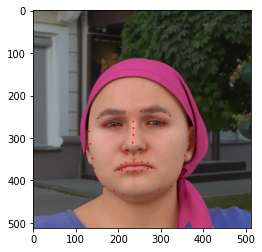

In [38]:
landmarks2d = np.dot(intrinsics, (landmarks3d / landmarks3d[:, 2].reshape(-1, 1)).transpose()).transpose()
landmark_show(item[Modality.RGB],  np.array([512, 0]) + landmarks2d[:,:2]  * [-1, 1])

In [44]:
intrinsics

array([[1.55151515e+03, 0.00000000e+00, 2.56000000e+02],
       [0.00000000e+00, 1.55151515e+03, 2.56000000e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [49]:
(intrinsics @ (landmarks3d / landmarks3d[:, 2].reshape(-1, 1) * [-1, 1, 1]).transpose()).transpose()

array([[131.88105362, 285.2036883 ,   1.        ],
       [134.64736027, 314.12721704,   1.        ],
       [139.89607858, 348.22632486,   1.        ],
       [143.75402648, 371.25058554,   1.        ],
       [151.61310882, 394.23621428,   1.        ],
       [166.80175589, 414.64978903,   1.        ],
       [190.62493722, 425.00116273,   1.        ],
       [212.14211081, 433.75509064,   1.        ],
       [241.53288807, 438.26597421,   1.        ],
       [272.018407  , 432.66793646,   1.        ],
       [296.91661604, 423.36763726,   1.        ],
       [324.75201165, 413.08164057,   1.        ],
       [342.38412146, 391.61311451,   1.        ],
       [351.55459681, 366.97650666,   1.        ],
       [356.48853784, 342.61419644,   1.        ],
       [364.60168157, 307.69975284,   1.        ],
       [364.49547493, 277.99764499,   1.        ],
       [152.30575788, 254.30461365,   1.        ],
       [163.05015468, 245.46840134,   1.        ],
       [178.23982427, 239.63880

In [40]:
landmarks2d

array([[380.11894638, 285.2036883 ,   1.        ],
       [377.35263973, 314.12721704,   1.        ],
       [372.10392142, 348.22632486,   1.        ],
       [368.24597352, 371.25058554,   1.        ],
       [360.38689118, 394.23621428,   1.        ],
       [345.19824411, 414.64978903,   1.        ],
       [321.37506278, 425.00116273,   1.        ],
       [299.85788919, 433.75509064,   1.        ],
       [270.46711193, 438.26597421,   1.        ],
       [239.981593  , 432.66793646,   1.        ],
       [215.08338396, 423.36763726,   1.        ],
       [187.24798835, 413.08164057,   1.        ],
       [169.61587854, 391.61311451,   1.        ],
       [160.44540319, 366.97650666,   1.        ],
       [155.51146216, 342.61419644,   1.        ],
       [147.39831843, 307.69975284,   1.        ],
       [147.50452507, 277.99764499,   1.        ],
       [359.69424212, 254.30461365,   1.        ],
       [348.94984532, 245.46840134,   1.        ],
       [333.76017573, 239.63880

In [71]:
landmarks2d[1]

 "screen_space_pos": [
                0.2576,
                0.557
            ],
            "ptnum": 0,
            "camera_space_pos": [
                -0.08461744338274002,
                -0.019909461960196495,
                -1.0577373504638672
            ],
            "distance_to_camera": 1.0613033771514893,
            "world_space_pos": [
                -0.0762530192732811,
                0.28439053893089294,
                -0.006627678871154785
            ]

array([377.35263973, 314.12721704,   1.        ])

In [65]:
np.dot(intrinsics, [landmarks3d[1][1],landmarks3d[1][0],landmarks3d[1][2]])

array([-332.089438  , -398.93017624,   -1.05718136])

In [81]:
 item[Modality.LANDMARKS]

array([[131.8912, 285.184 ],
       [134.656 , 314.112 ],
       [139.8784, 348.2112],
       [143.7696, 371.2512],
       [151.6032, 394.24  ],
       [166.8096, 414.6688],
       [190.6176, 425.0112],
       [212.1216, 433.7664],
       [241.5104, 438.272 ],
       [272.0256, 432.6912],
       [296.9088, 423.3728],
       [324.7616, 413.0816],
       [342.3744, 391.6288],
       [351.5392, 367.0016],
       [356.5056, 342.6304],
       [364.5952, 307.712 ],
       [364.4928, 278.016 ],
       [152.32  , 254.3104],
       [163.072 , 245.4528],
       [178.2272, 239.616 ],
       [195.2256, 237.6192],
       [214.8864, 239.9744],
       [253.9008, 238.4384],
       [273.4592, 234.496 ],
       [292.1472, 235.9296],
       [309.9648, 240.5888],
       [322.7136, 248.1152],
       [235.8272, 261.5296],
       [235.8272, 277.3504],
       [235.1104, 293.0688],
       [234.1376, 311.0912],
       [209.1008, 332.0832],
       [222.0544, 337.8176],
       [236.6464, 339.712 ],
       [252.10

In [85]:
landmarks2d[:, :2]

array([[380.11894638, 285.2036883 ],
       [377.35263973, 314.12721704],
       [372.10392142, 348.22632486],
       [368.24597352, 371.25058554],
       [360.38689118, 394.23621428],
       [345.19824411, 414.64978903],
       [321.37506278, 425.00116273],
       [299.85788919, 433.75509064],
       [270.46711193, 438.26597421],
       [239.981593  , 432.66793646],
       [215.08338396, 423.36763726],
       [187.24798835, 413.08164057],
       [169.61587854, 391.61311451],
       [160.44540319, 366.97650666],
       [155.51146216, 342.61419644],
       [147.39831843, 307.69975284],
       [147.50452507, 277.99764499],
       [359.69424212, 254.30461365],
       [348.94984532, 245.46840134],
       [333.76017573, 239.63880788],
       [316.75430171, 237.60409701],
       [297.09028601, 239.97378745],
       [258.08944261, 238.42836244],
       [238.52775335, 234.50386756],
       [219.84136353, 235.90578321],
       [202.04927807, 240.58204957],
       [189.26845423, 248.10491046],
 

In [33]:
plt.figure(figsize=(20,20))
gaze_show(item[Modality.RGB], item[Modality.PUPILS], item[Modality.GAZE])

ValueError: operands could not be broadcast together with shapes (2,2) (2,3) 

<Figure size 1440x1440 with 0 Axes>

In [ ]:
plt.figure(figsize=(20,20))
gaze_show(item2[Modality.RGB], item2[Modality.PUPILS], item2[Modality.GAZE])

In addition there are modalities to represent different kind of metadata:

Identity (for face_id tasks)

In [ ]:
item[Modality.IDENTITY]

Identity metadata, such as age or gender.

In [ ]:
item[Modality.IDENTITY_METADATA]

Information about hairstyle.

In [ ]:
item[Modality.HAIR]

Information about facial hair.

In [ ]:
item2[Modality.FACIAL_HAIR]

If corresponding attribute is not present on the image, the modality is `None`.

In [ ]:
item[Modality.FACIAL_HAIR]

Expression modality shows facial expression and its intensity.

In [ ]:
item[Modality.EXPRESSION]

Usually not all the modalities are needed, so we can only load selected modalities in the dataset.

In [ ]:
dataset2 = FaceApiDataset("test_dataset", modalities=[Modality.RGB, Modality.SEGMENTS], segments=segments)

In [ ]:
dataset2[0].keys()

Usually there are no problems with the amount of synthetic images,
however augmentations are still useful as they help to bridge the reality gap.
We can provide transformations in dataset constructor to implement augmentations needed.

Below we show how to use `albumentations` library with Synthesis AI dataset for the segmentation task.

In [ ]:
import albumentations as A

In [ ]:
aug = A.Sequential([A.RandomRotate90(p=1), A.GridDistortion(p=1)])

def transform(item):
    augmented = aug(image=item[Modality.RGB], mask=item[Modality.SEGMENTS])
    return {
        Modality.RGB: augmented['image'],
        Modality.SEGMENTS: augmented['mask']
    }

dataset3 = FaceApiDataset("test_dataset", modalities=[Modality.RGB, Modality.SEGMENTS],
                          segments=segments, transform=transform)

aug_item = dataset3[0]
aug_item2 = dataset3[0]

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(aug_item[Modality.RGB])


In [ ]:
plt.figure(figsize=(20,20))
discrete_show(aug_item[Modality.SEGMENTS])


In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(aug_item2[Modality.RGB])

In [ ]:
plt.figure(figsize=(20,20))
discrete_show(aug_item2[Modality.SEGMENTS])
